**Train an autoencoder (very similar to autoencoder.ipynb) on several types of histograms and study the combined prediction**

Note: this is quite long and complicated script that is quite flexible in the method of training and testing. It is not so much a fixed and fully worked out tutorial, but rather a development script. In fact, many of the results I showed in "recent" DQM/DC general meetings were obtained with this script.

In [1]:
### imports

# external modules
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import importlib

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)

Using TensorFlow backend.


<module 'GaussianKdeFitter' from '../src/cloudfitters/GaussianKdeFitter.py'>

In [2]:
### define run properties
# in this cell all major run properties are going to be set,
# e.g. what runs to train on and what runs to test on

# define a list of good 'reference' runs (found by eye)
# should be replaced at some point by the reference runs defined by the DQM/DC team.
goodrunsls = {'2017':
              {
                "297056":[[-1]],
                "297177":[[-1]],
                "301449":[[-1]],
              },
              '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
             {  "315267":[[-1]] 
             }}

# define core test set of clearly bad runs (found by eye)
badrunsls = {'2017':
                {
                "297287":[[-1]],
                "297288":[[-1]],
                "297289":[[-1]],
                "299316":[[-1]],
                "299324":[[-1]],
                "299326":[[-1]],
                "301086":[[88,126]] # only bad for size_PXDisk_+1 -> maybe do not use for now (unclear what are real anomalies)
                },
            '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
                {
                #"317479":[[-1]],
                "317480":[[-1]],
                "317481":[[-1]],
                "317482":[[-1]],
                #"319847":[[1,35]]
            }}

# set year to use
year = '2017'

# set histogram names to use 
histnames = [
            'chargeInner_PXLayer_2',
             'chargeInner_PXLayer_3',
             'charge_PXDisk_+1','charge_PXDisk_+2','charge_PXDisk_+3',
             'size_PXLayer_1','size_PXLayer_2',
             'size_PXLayer_3'
            ]

# set whether to train globally or locally
training_mode = 'local'

if training_mode == 'global':
    runsls_training = None # use none to not add a mask for training (can e.g. use DCS-bit on mask)
    runsls_good = None # use none to not add a mask for good runs (can e.g. use templates)
    runsls_bad = badrunsls[year] # predefined bad runs
    print('selected runs/lumisections for training: all')
    
elif training_mode == 'local':
    # train locally on a small set of runs
    # - either on n runs preceding a chosen application run,
    # - or on the run associated as reference to the chosen application run.
    
    # select application run
    available_runs = dfu.get_runs( dfu.select_dcson( csvu.read_csv('../data/DF'+year+'_'+histnames[0]+'.csv') ) )
    run_application = 305351
    run_application_index = available_runs.index(run_application)
    # select training set
    usereference = False
    if usereference:
        run_reference = rru.get_reference_run( run_application, jsonfile='../utils/json_allRunsRefRuns.json' )
        if run_reference<0:
            raise Exception('no valid reference run has been defined for run {}'.format(run_application))
        runsls_training = jsonu.tuplelist_to_jsondict([(run_reference,[-1])])
    else:
        ntraining = 5
        runsls_training = jsonu.tuplelist_to_jsondict([(el,[-1]) for el in available_runs[run_application_index-ntraining:run_application_index]])
    runsls_bad = badrunsls[year]
    runsls_good = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)

selected runs/lumisections for training: 
{'305336': [[-1]], '305338': [[-1]], '305341': [[-1]], '305349': [[-1]], '305350': [[-1]]}
selected runs/lumisections as good test set:
{'305351': [[-1]]}
selected runs/lumisections as bad test set:
{'297287': [[-1]], '297288': [[-1]], '297289': [[-1]], '299316': [[-1]], '299324': [[-1]], '299326': [[-1]], '301086': [[88, 126]]}


In [3]:
### read the data based on the configuration defined above

readnew = True
save = False

if readnew:
    
    # add the histograms
    histstruct = HistStruct.HistStruct()
    # loop over the histogram types to take into account
    for histname in histnames:
        print('adding {}...'.format(histname))
        # read the histograms from the csv file
        filename = '../data/DF2017_'+histname+'.csv'
        df = csvu.read_csv( filename )
        # in case of local training, we can remove most of the histograms
        if( runsls_training is not None and runsls_good is not None and runsls_bad is not None ):
            runsls_total = {k: v for d in (runsls_training, runsls_good, runsls_bad) for k, v in d.items()}
            df = dfu.select_runsls( df, runsls_total )
        histstruct.add_dataframe( df )
    print('found {} histograms'.format(len(histstruct.runnbs)))
    
    # add masks
    histstruct.add_dcsonjson_mask( 'dcson' )
    histstruct.add_goldenjson_mask('golden' )
    histstruct.add_hightstat_mask( 'highstat' )
    if runsls_training is not None: histstruct.add_json_mask( 'training', runsls_training )
    if runsls_good is not None: histstruct.add_json_mask( 'good', runsls_good )
    nbadruns = 0
    if runsls_bad is not None:
        # special case for bad runs: add a mask per run (different bad runs have different characteristics)
        nbadruns = len(runsls_bad.keys())
        for i,badrun in enumerate(runsls_bad.keys()):
            histstruct.add_json_mask( 'bad{}'.format(i), {badrun:runsls_bad[badrun]} )
    
    if save:
        histstruct.save( 'test.pkl' )
        
if not readnew:
    
    histstruct = HistStruct.HistStruct.load( 'test.pkl' )
    nbadruns = len([name for name in list(histstruct.masks.keys()) if 'bad' in name])
    
print('created a histstruct with the following properties:')
print('- number of histogram types: {}'.format(len(histstruct.histnames)))
print('- number of lumisections: {}'.format(len(histstruct.lsnbs)))
print('- masks: {}'.format(list(histstruct.masks.keys())))

adding chargeInner_PXLayer_2...
adding chargeInner_PXLayer_3...
adding charge_PXDisk_+1...
adding charge_PXDisk_+2...
adding charge_PXDisk_+3...
adding size_PXLayer_1...
adding size_PXLayer_2...
adding size_PXLayer_3...
found 1961 histograms
created a histstruct with the following properties:
- number of histogram types: 8
- number of lumisections: 1961
- masks: ['dcson', 'golden', 'highstat', 'training', 'good', 'bad0', 'bad1', 'bad2', 'bad3', 'bad4', 'bad5', 'bad6']


making plot for chargeInner_PXLayer_2
making plot for chargeInner_PXLayer_3
making plot for charge_PXDisk_+1
making plot for charge_PXDisk_+2
making plot for charge_PXDisk_+3
making plot for size_PXLayer_1
making plot for size_PXLayer_2
making plot for size_PXLayer_3
making plot for chargeInner_PXLayer_2
making plot for chargeInner_PXLayer_3
making plot for charge_PXDisk_+1
making plot for charge_PXDisk_+2
making plot for charge_PXDisk_+3
making plot for size_PXLayer_1
making plot for size_PXLayer_2
making plot for size_PXLayer_3


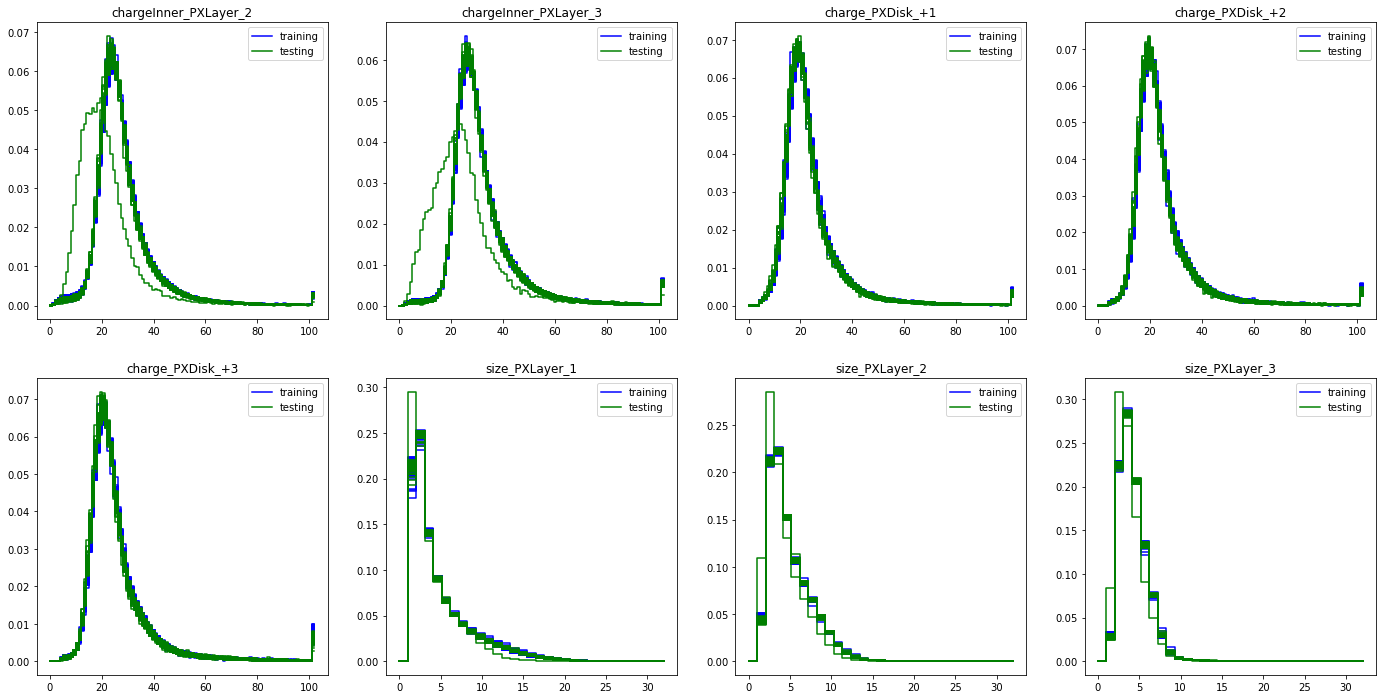

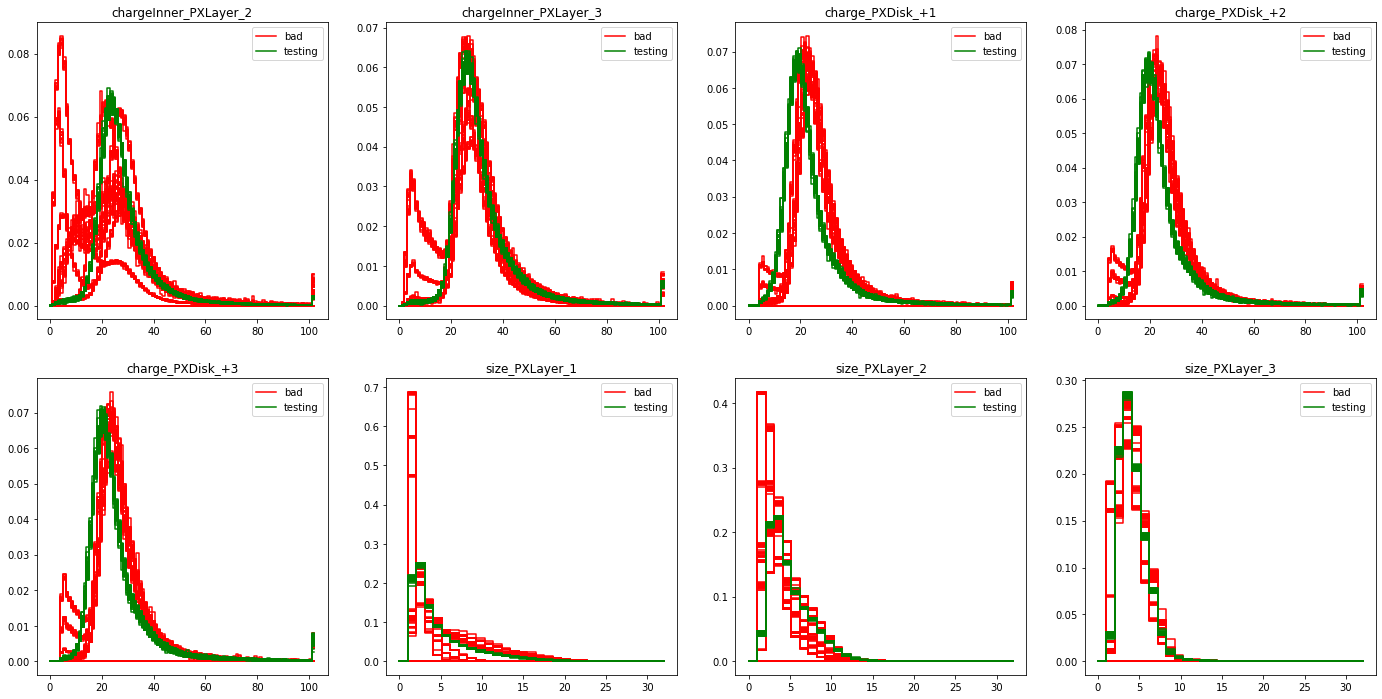

In [4]:
### plot the training and/or test sets
# especially useful if running in local mode to check if training set is relevant for targeted application run,
# and if the application run contains anomalies

skipthiscell = False

if( training_mode=='local' and not skipthiscell ):
    
    # training and application runs
    fig,axs = plt.subplots(2,4,figsize=(24,12))
    for j,name in enumerate(histstruct.histnames):
        print('making plot for '+name)
        hists_training = histstruct.get_histograms(histname=name,masknames=['dcson','highstat','training'])
        hists_testing = histstruct.get_histograms(histname=name,masknames=['highstat','good'])
        pu.plot_sets([hists_training,hists_testing],
                  fig=fig,
                  ax=axs[int(j/4),j%4],
                  title=name,
                  colorlist=['blue','green'],labellist=['training','testing'],
                  transparencylist=[1.,1.])
    
    # application run and bad test runs
    fig,axs = plt.subplots(2,4,figsize=(24,12))
    for j,name in enumerate(histstruct.histnames):
        print('making plot for '+name)
        hists_good = histstruct.get_histograms(histname=name,masknames=['dcson','highstat','good'])
        hists_bad = histstruct.get_histograms(histname=name,masknames=['bad0'])
        for i in range(nbadruns)[1:]:
            hists_bad = np.vstack((hists_bad,histstruct.get_histograms(histname=name,masknames=['bad{}'.format(i)])))
        pu.plot_sets([hists_bad,hists_good],
                  fig=fig,
                  ax=axs[int(j/4),j%4],
                  title=name,
                  colorlist=['red','green'],labellist=['bad','testing'],
                  transparencylist=[1.,1.])

generating artificial training data for chargeInner_PXLayer_2
 -> generated 49920 histograms
generating artificial training data for chargeInner_PXLayer_3
 -> generated 49920 histograms
generating artificial training data for charge_PXDisk_+1
 -> generated 49920 histograms
generating artificial training data for charge_PXDisk_+2
 -> generated 49920 histograms
generating artificial training data for charge_PXDisk_+3
 -> generated 49920 histograms
generating artificial training data for size_PXLayer_1
 -> generated 49920 histograms
generating artificial training data for size_PXLayer_2


../utils/generate_data_utils.py:145: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()


 -> generated 49920 histograms
generating artificial training data for size_PXLayer_3
 -> generated 49920 histograms


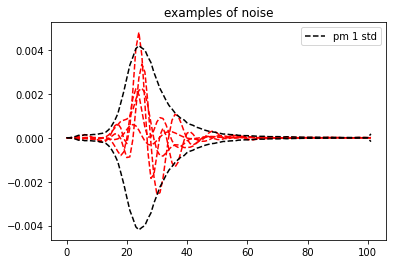

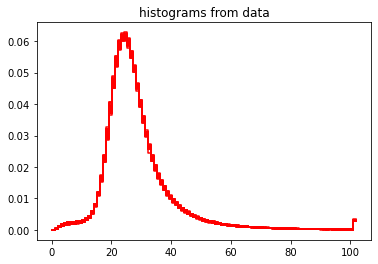

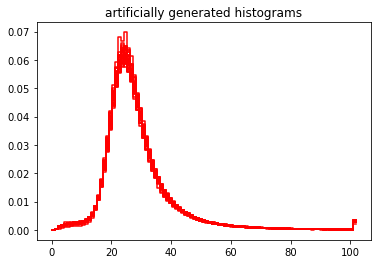

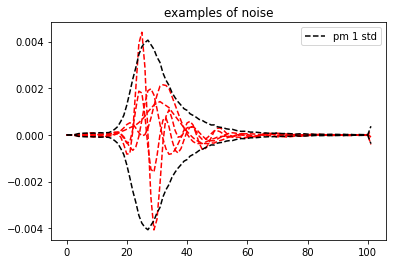

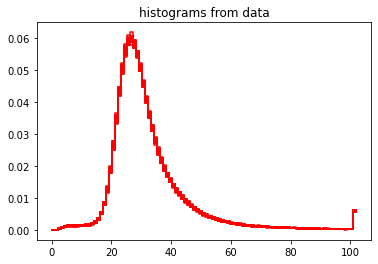

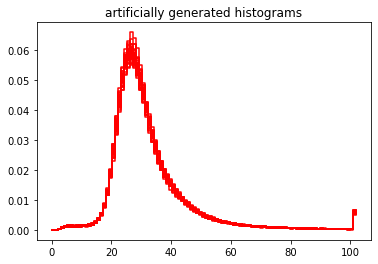

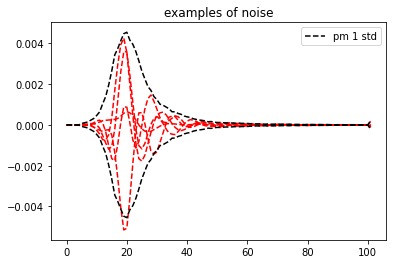

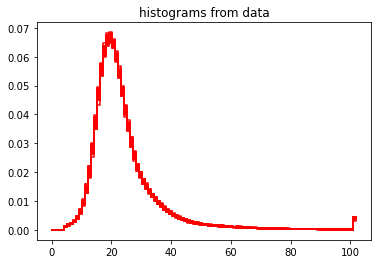

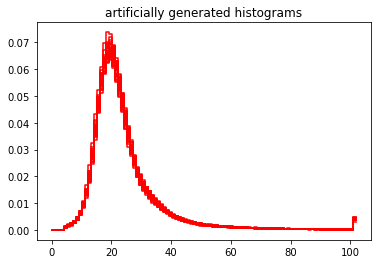

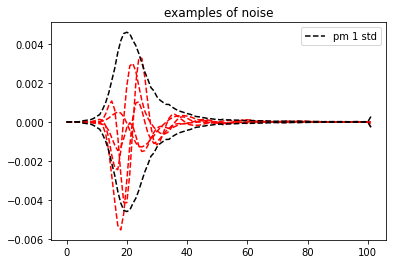

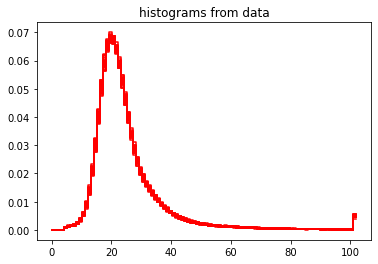

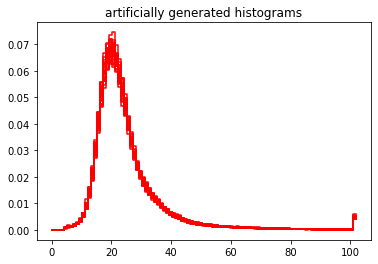

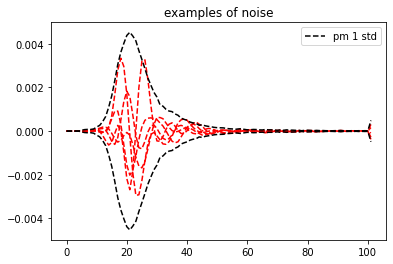

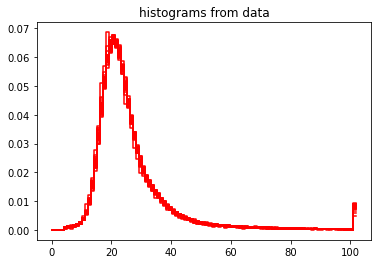

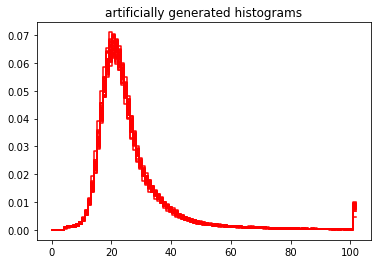

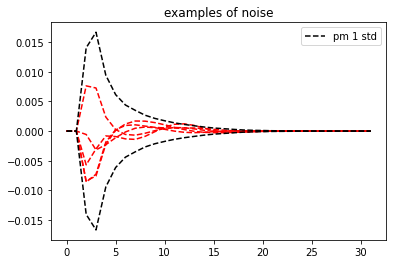

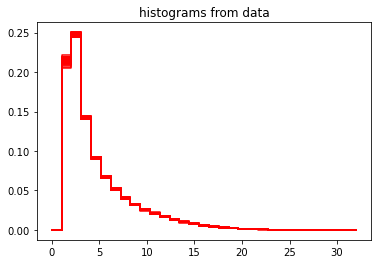

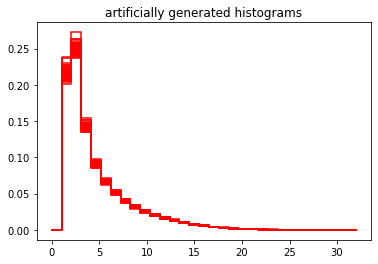

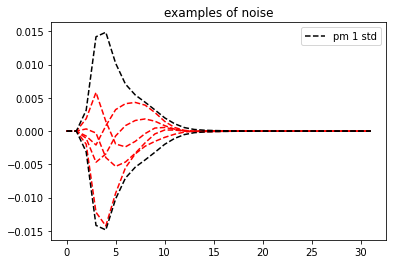

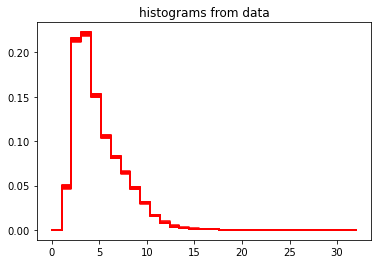

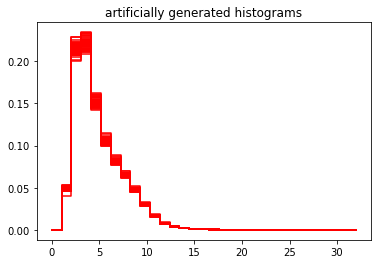

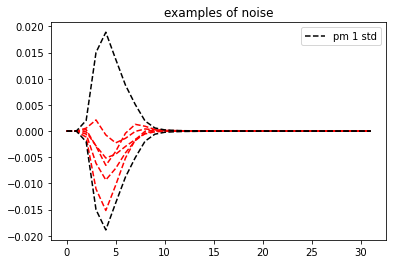

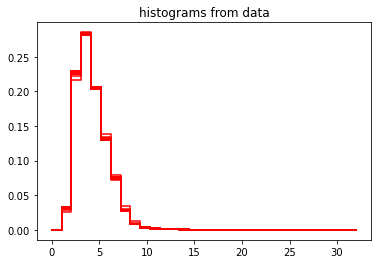

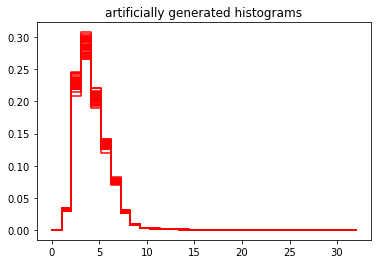

In [5]:
### extend the training set using artificial data

extendtraining = True

if extendtraining:
    histstruct.exthistograms['training'] = {}
    for histname,hists in histstruct.get_histograms( masknames=['dcson','highstat','training'] ).items():
        print('generating artificial training data for '+histname)
        histstruct.exthistograms['training'][histname] = gdu.upsample_hist_set(hists,5e4)
        print(' -> generated {} histograms'.format(len(histstruct.exthistograms['training'][histname])))

size of training set: (49920, 102)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 51)                5253      
_________________________________________________________________
dense_1 (Dense)              (None, 102)               5304      
Total params: 10,557
Trainable params: 10,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
90/90 [==============================] - 1s 9ms/step - loss: 3.4702e-04 - val_loss: 4.4032e-06
Epoch 2/40
90/90 [==============================] - 1s 7ms/step - loss: 4.2687e-06 - val_loss: 4.1964e-06
Epoch 3/40
90/90 [==============================] - 1s 8ms/step - loss: 4.1442e-06 - val_loss: 4.0817e-06
Epoch 4/40
90/90 [==============================] - 1s 7ms/step - loss: 4.0252e-06 - val_loss: 3.9591e-06
Epoch 5/40
90/90 [==============================] - 1s 

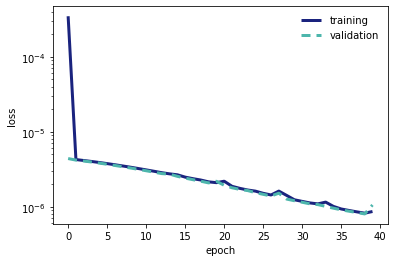

size of training set: (49920, 102)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 51)                5253      
_________________________________________________________________
dense_3 (Dense)              (None, 102)               5304      
Total params: 10,557
Trainable params: 10,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
90/90 [==============================] - 1s 10ms/step - loss: 2.8935e-04 - val_loss: 4.3545e-06
Epoch 2/40
90/90 [==============================] - 1s 8ms/step - loss: 4.2205e-06 - val_loss: 4.2021e-06
Epoch 3/40
90/90 [==============================] - 1s 8ms/step - loss: 4.1172e-06 - val_loss: 4.1025e-06
Epoch 4/40
90/90 [==============================] - 1s 8ms/step - loss: 4.0117e-06 - val_loss: 3.9904e-06
Epoch 5/40
90/90 [==============================] - 

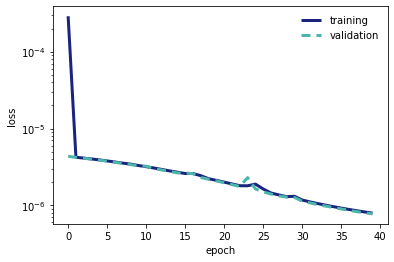

size of training set: (49920, 102)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 51)                5253      
_________________________________________________________________
dense_5 (Dense)              (None, 102)               5304      
Total params: 10,557
Trainable params: 10,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
90/90 [==============================] - 1s 10ms/step - loss: 2.5792e-04 - val_loss: 5.6706e-06
Epoch 2/40
90/90 [==============================] - 1s 8ms/step - loss: 5.4090e-06 - val_loss: 5.4151e-06
Epoch 3/40
90/90 [==============================] - 1s 8ms/step - loss: 5.2012e-06 - val_loss: 5.2026e-06
Epoch 4/40
90/90 [==============================] - 1s 8ms/step - loss: 4.9906e-06 - val_loss: 4.9785e-06
Epoch 5/40
90/90 [==============================] - 

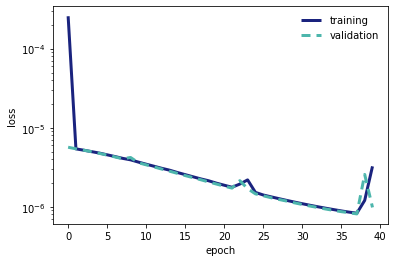

size of training set: (49920, 102)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 51)                5253      
_________________________________________________________________
dense_7 (Dense)              (None, 102)               5304      
Total params: 10,557
Trainable params: 10,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
90/90 [==============================] - 1s 8ms/step - loss: 3.2329e-04 - val_loss: 5.5585e-06
Epoch 2/40
90/90 [==============================] - 1s 6ms/step - loss: 5.4721e-06 - val_loss: 5.2418e-06
Epoch 3/40
90/90 [==============================] - 1s 6ms/step - loss: 5.1789e-06 - val_loss: 4.9705e-06
Epoch 4/40
90/90 [==============================] - 1s 6ms/step - loss: 4.9145e-06 - val_loss: 4.7100e-06
Epoch 5/40
90/90 [==============================] - 1

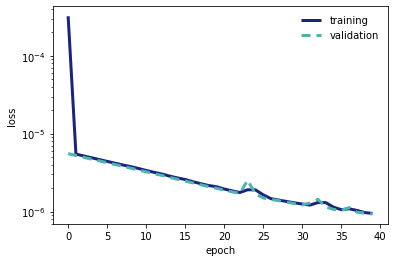

size of training set: (49920, 102)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 51)                5253      
_________________________________________________________________
dense_9 (Dense)              (None, 102)               5304      
Total params: 10,557
Trainable params: 10,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
90/90 [==============================] - 1s 9ms/step - loss: 3.7653e-04 - val_loss: 6.2803e-06
Epoch 2/40
90/90 [==============================] - 1s 8ms/step - loss: 5.9879e-06 - val_loss: 5.8945e-06
Epoch 3/40
90/90 [==============================] - 1s 8ms/step - loss: 5.6840e-06 - val_loss: 5.5994e-06
Epoch 4/40
90/90 [==============================] - 1s 7ms/step - loss: 5.4034e-06 - val_loss: 5.3313e-06
Epoch 5/40
90/90 [==============================] - 1

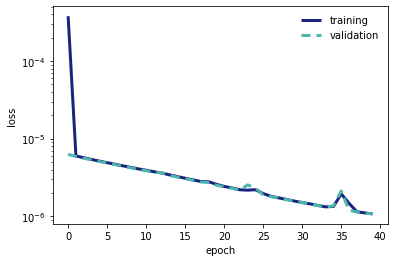

size of training set: (49920, 32)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 32)                544       
Total params: 1,072
Trainable params: 1,072
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
90/90 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 1.6984e-05
Epoch 2/40
90/90 [==============================] - 0s 4ms/step - loss: 1.2263e-05 - val_loss: 1.1801e-05
Epoch 3/40
90/90 [==============================] - 0s 3ms/step - loss: 1.1378e-05 - val_loss: 1.1530e-05
Epoch 4/40
90/90 [==============================] - 0s 3ms/step - loss: 1.1121e-05 - val_loss: 1.1259e-05
Epoch 5/40
90/90 [==============================] - 0s 3ms/s

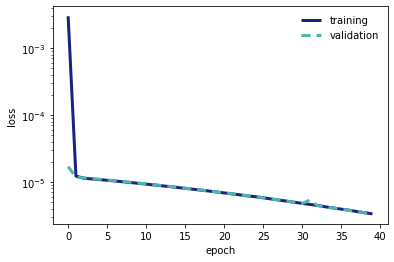

size of training set: (49920, 32)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                544       
Total params: 1,072
Trainable params: 1,072
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
90/90 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 1.6667e-05
Epoch 2/40
90/90 [==============================] - 0s 3ms/step - loss: 1.1720e-05 - val_loss: 1.0565e-05
Epoch 3/40
90/90 [==============================] - 0s 3ms/step - loss: 1.0477e-05 - val_loss: 1.0245e-05
Epoch 4/40
90/90 [==============================] - 0s 3ms/step - loss: 1.0180e-05 - val_loss: 9.9760e-06
Epoch 5/40
90/90 [==============================] - 0s 2ms/s

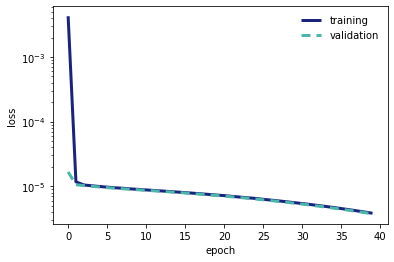

size of training set: (49920, 32)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_15 (Dense)             (None, 32)                544       
Total params: 1,072
Trainable params: 1,072
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
90/90 [==============================] - 1s 6ms/step - loss: 0.0074 - val_loss: 1.5453e-05
Epoch 2/40
90/90 [==============================] - 0s 4ms/step - loss: 1.5105e-05 - val_loss: 1.3773e-05
Epoch 3/40
90/90 [==============================] - 0s 4ms/step - loss: 1.3900e-05 - val_loss: 1.3545e-05
Epoch 4/40
90/90 [==============================] - 0s 3ms/step - loss: 1.3685e-05 - val_loss: 1.3344e-05
Epoch 5/40
90/90 [==============================] - 0s 3ms/s

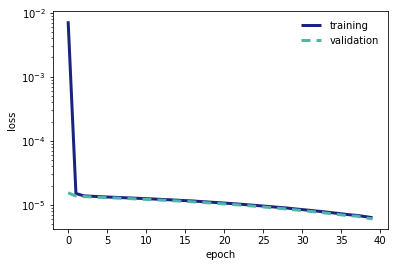

In [6]:
### define and train an autoencoder for each element
from keras.models import load_model

trainnew = True

if trainnew:
    for histname,hists in histstruct.get_histograms( masknames=['dcson','highstat'] ).items():
        if extendtraining: hists = histstruct.exthistograms['training'][histname]
        print('size of training set: {}'.format(hists.shape))
        nepochs = 40 # manual number of epochs
        model = aeu.train_simple_autoencoder(hists,nepochs=nepochs,modelname='')
        classifier = AutoEncoder.AutoEncoder( model=model )
        histstruct.add_classifier(histname,classifier)

In [7]:
### evaluate the models on all histograms in the (non-extended) histstruct

mse_train = []
mse_good = []
mse_bad = []
for i in range(nbadruns): mse_bad.append([])
for histname in histstruct.histnames:
    print('evaluating model for '+histname)
    histstruct.evaluate_classifier(histname)
    # get mse for training set
    thismse = histstruct.get_scores( histname=histname, masknames=['dcson','highstat', 'training'] )
    mse_train.append( thismse )
    # alternative way of evaluation
    #thismse2 = histstruct.classifiers[histname].evaluate( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat','training'] ) )
    # get mse for good set
    if 'good' in histstruct.masks.keys(): 
        thismse = histstruct.get_scores( histname=histname, masknames=['highstat','good'] )
        mse_good.append( thismse )
    # alternative way of evaluation
    #thismse2 = histstruct.classifiers[histname].evaluate( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat','good'] ) )
    # get mse for bad sets
    for i in range(nbadruns):
        thismse = histstruct.get_scores( histname=histname, masknames=['dcson','highstat','bad{}'.format(i)] )
        mse_bad[i].append( thismse )
        
# transform to arrays with correct shape
mse_train = np.array(mse_train)
mse_train = np.transpose(mse_train)
print('found mse array for training set of following shape: {}'.format(mse_train.shape))
mse_good = np.array(mse_good)
mse_good = np.transpose(mse_good)
print('found mse array for good set of following shape: {}'.format(mse_good.shape))
for i in range(nbadruns):
    mse_bad[i] = np.array(mse_bad[i])
    mse_bad[i] = np.transpose(mse_bad[i])
    print('found mse array for bad set of following shape: {}'.format(mse_bad[i].shape))

evaluating model for chargeInner_PXLayer_2
evaluating model for chargeInner_PXLayer_3
evaluating model for charge_PXDisk_+1
evaluating model for charge_PXDisk_+2
evaluating model for charge_PXDisk_+3
evaluating model for size_PXLayer_1
evaluating model for size_PXLayer_2
evaluating model for size_PXLayer_3
found mse array for training set of following shape: (832, 8)
found mse array for good set of following shape: (859, 8)
found mse array for bad set of following shape: (15, 8)
found mse array for bad set of following shape: (15, 8)
found mse array for bad set of following shape: (15, 8)
found mse array for bad set of following shape: (43, 8)
found mse array for bad set of following shape: (9, 8)
found mse array for bad set of following shape: (22, 8)
found mse array for bad set of following shape: (29, 8)


../utils/plot_utils.py:361: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  (fig,ax) = plt.subplots()


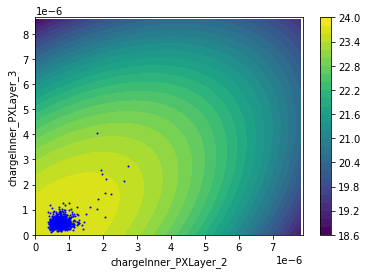

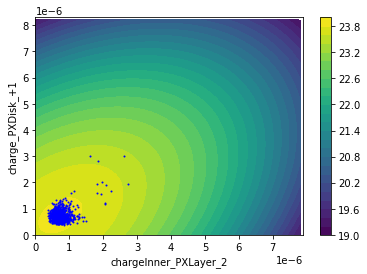

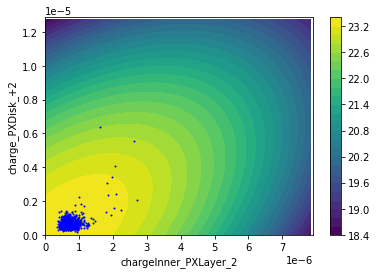

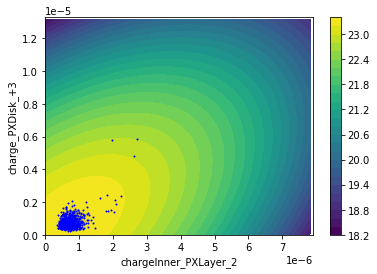

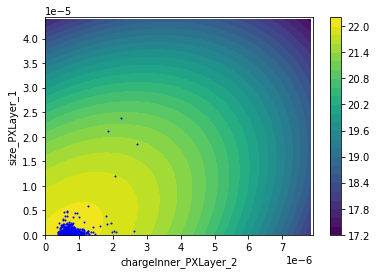

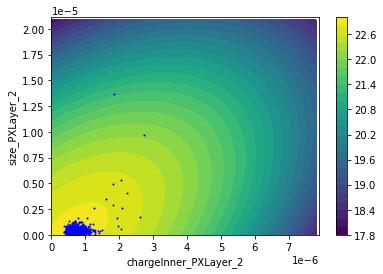

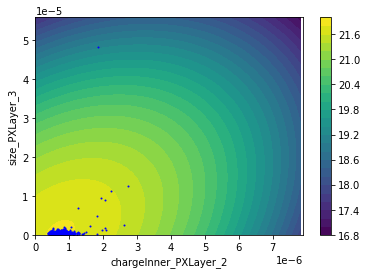

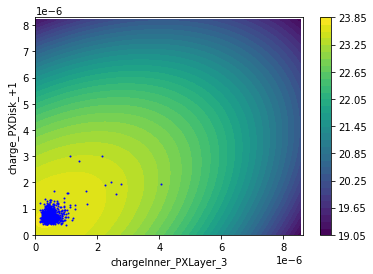

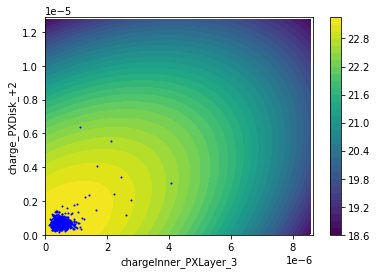

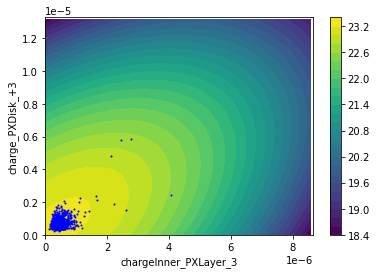

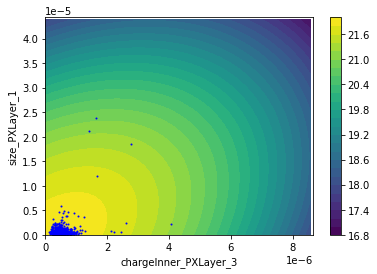

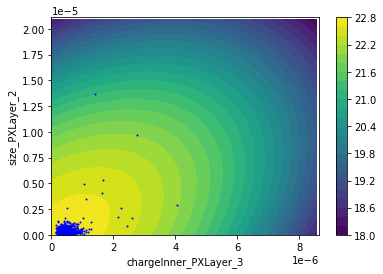

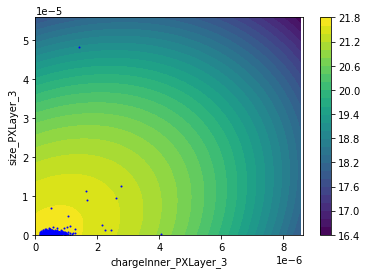

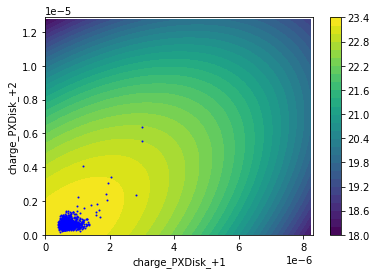

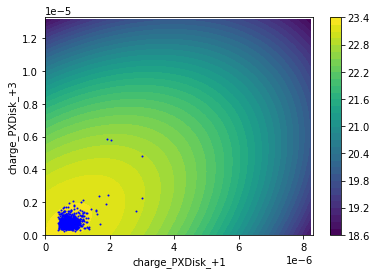

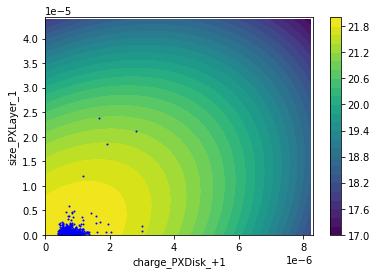

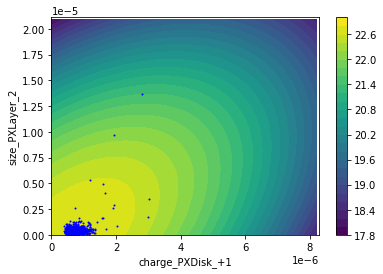

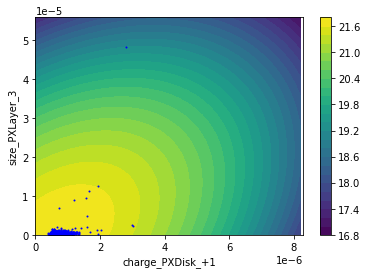

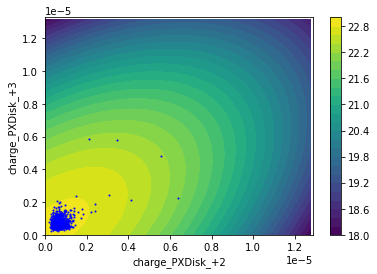

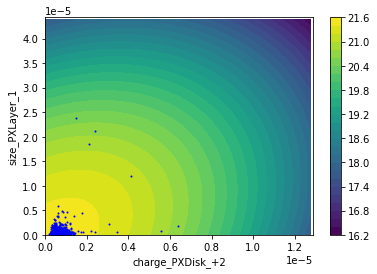

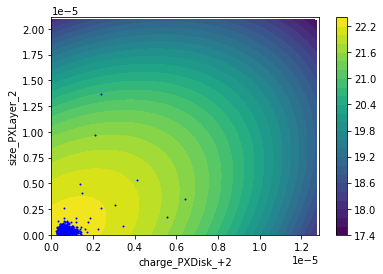

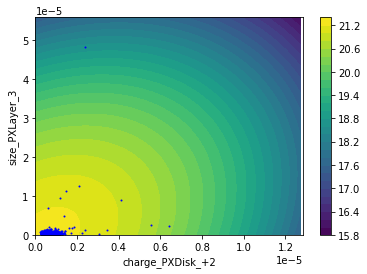

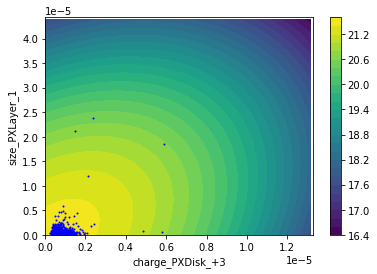

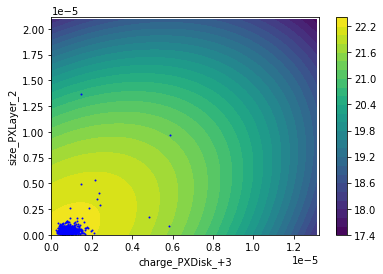

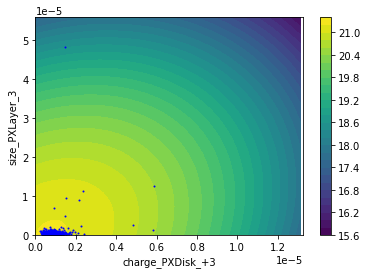

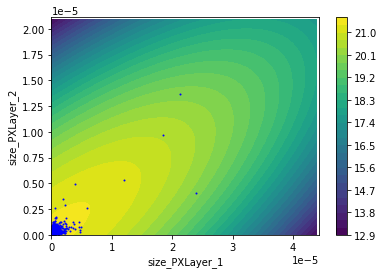

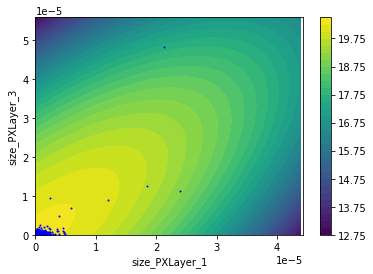

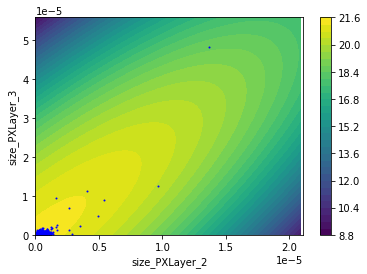

In [8]:
### plot the multidemensional mse and fit a distribution
import matplotlib as mpl

dimslist = []
fitfunclist = []
nhisttypes = len(histstruct.histnames)
for i in range(0,nhisttypes-1):
    for j in range(i+1,nhisttypes):
        dimslist.append((i,j))

plt.close('all')
(npoints,ndims) = mse_train.shape
scott_bw = npoints**(-1./(ndims+4))
bw_method = 20*scott_bw
for dims in dimslist:
   
    thismse = mse_train[:,dims]
    #fitfunc = SeminormalFitter.SeminormalFitter(thismse)
    fitfunc = GaussianKdeFitter.GaussianKdeFitter(thismse,bw_method=bw_method)
    pu.plot_fit_2d(thismse, fitfunc=fitfunc, logprob=True, onlycontour=False, xlims=30, ylims=30, 
                    onlypositive=True, xaxtitle=histstruct.histnames[dims[0]], 
                    yaxtitle=histstruct.histnames[dims[1]])
    #plt.close('all') # release plot memory
    fitfunclist.append(fitfunc)
    
#fitfunc = SeminormalFitter.SeminormalFitter(mse_train)
fitfunc = GaussianKdeFitter.GaussianKdeFitter(mse_train,bw_method=bw_method)

In [9]:
### extend the test set using artificial data generation and evaluate the model on the extended test set

skipthiscell = True # to prevent running this cell by accident

if not skipthiscell:
    
    histstruct.exthistograms['good'] = {}
    for i in range(nbadruns): histstruct.exthistograms['bad{}'.format(i)] = {}
    for histname in histstruct.histnames:
        print('generating data for '+histname)
        if 'good' in histstruct.masks.keys():
            goodhists = histstruct.get_histograms( histname=histname,masknames=['dcson','highstat','good'] )
        else:
            goodhists = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat'] ), 15 )
        histstruct.exthistograms['good'][histname] = gdu.upsample_hist_set( goodhists,
                                                    figname='',ntarget=nbadruns*5e3,fourierstdfactor=20.)
        # alternative: copy original good set (e.g. for using resampled bad but original good)
        #histstruct.exthistograms['good'][name] = goodhists
        for i in range(nbadruns):
            badhists = histstruct.get_histograms( histname=histname,masknames=['bad{}'.format(i)] )
            histstruct.exthistograms['bad{}'.format(i)][histname] = gdu.upsample_hist_set(
                badhists,figname='',ntarget=5e3,fourierstdfactor=20.)
            
    mse_good_ext = []
    mse_bad_ext = []
    for i in range(nbadruns): mse_bad_ext.append( [] )

    for histname in histstruct.histnames:
        print('evaluating: '+histname)
        # calculate mse for good test set
        mse = histstruct.classifiers[histname].evaluate( histstruct.exthistograms['good'][histname] )
        mse_good_ext.append(mse)
        for i in range(nbadruns):
            # calculate mse
            mse = histstruct.classifiers[histname].evaluate( histstruct.exthistograms['bad{}'.format(i)][histname] )
            mse_bad_ext[i].append(mse)
    
    # transform to arrays with correct shape
    mse_good_ext = np.array(mse_good_ext)
    mse_good_ext = np.transpose(mse_good_ext)
    print('found mse array for good set of following shape: {}'.format(mse_good_ext.shape))
    for i in range(nbadruns):
        mse_bad_ext[i] = np.array(mse_bad_ext[i])
        mse_bad_ext[i] = np.transpose(mse_bad_ext[i])
        print('found mse array for bad set of following shape: {}'.format(mse_bad_ext[i].shape))

../utils/plot_utils.py:361: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  (fig,ax) = plt.subplots()


--- good lumesections ---
length of log prob array: 859
minimum of log prob: -inf
--- bad lumisections ---
length of log prob array: 148
maximum of log prob: -inf


<ipython-input-10-dea81b614077>:30: RuntimeWarning: divide by zero encountered in log
  logprob_good = np.log(fitfunc.pdf(mse_good_eval))
<ipython-input-10-dea81b614077>:35: RuntimeWarning: divide by zero encountered in log
  logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(nbadruns)]


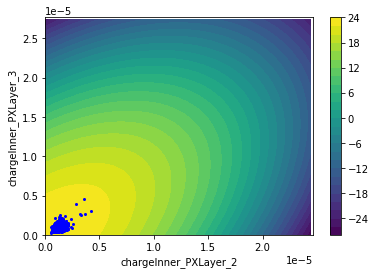

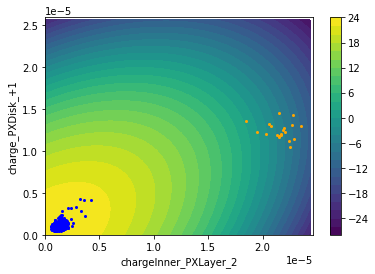

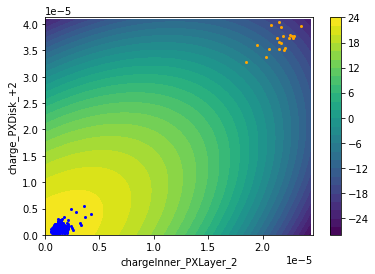

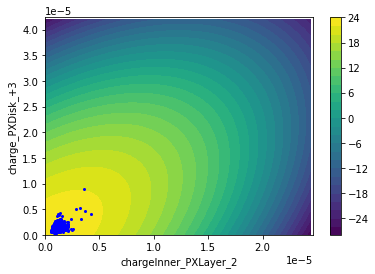

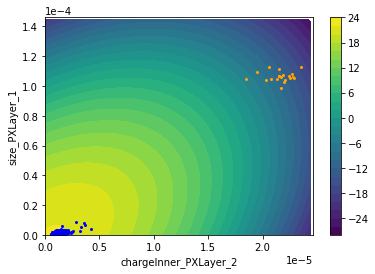

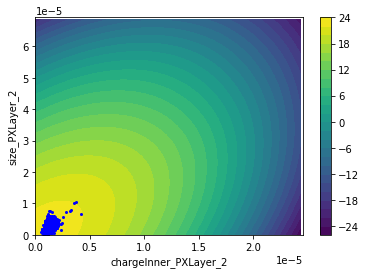

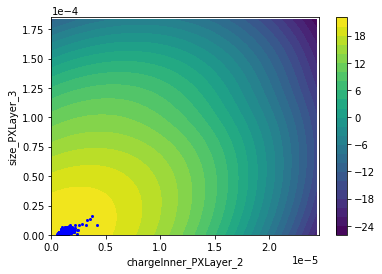

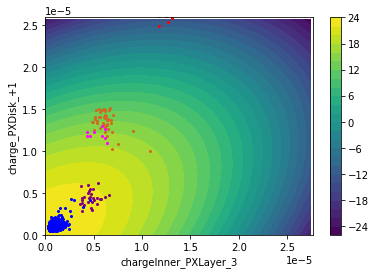

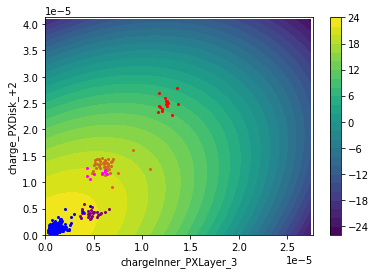

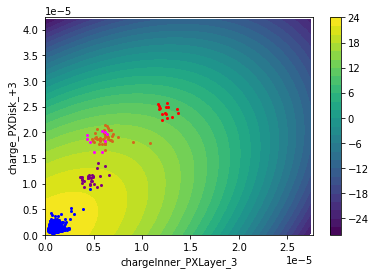

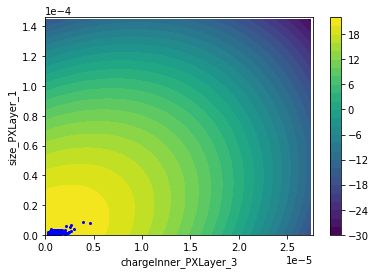

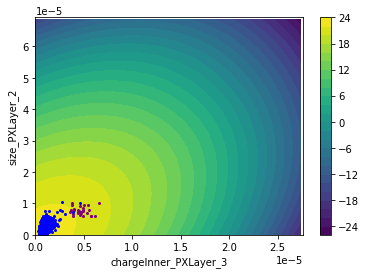

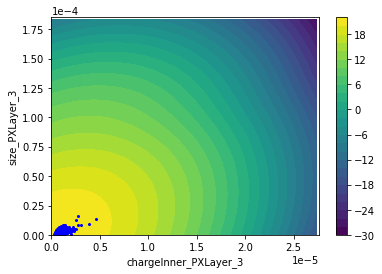

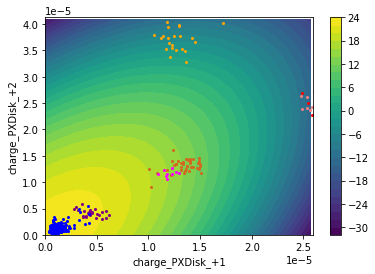

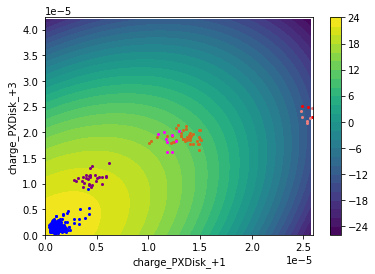

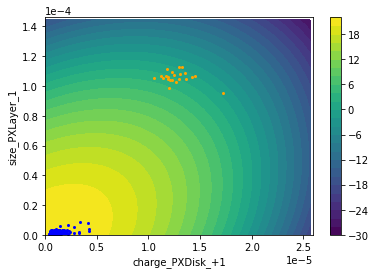

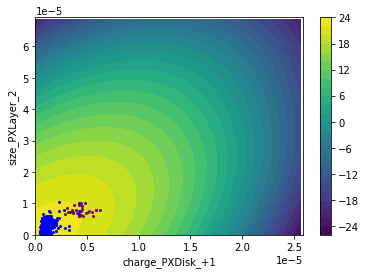

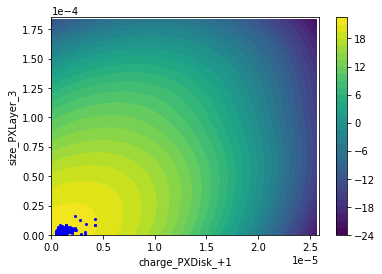

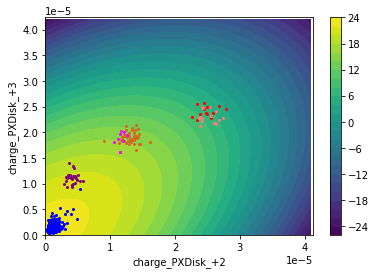

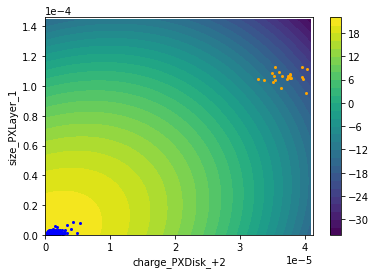

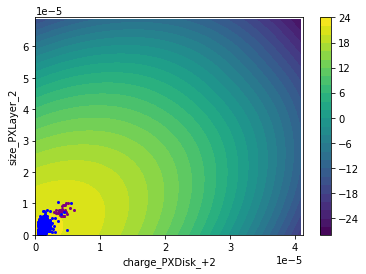

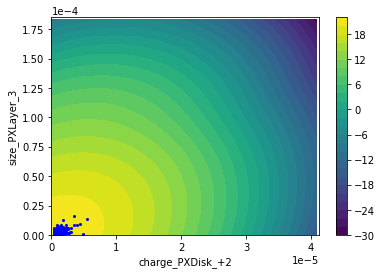

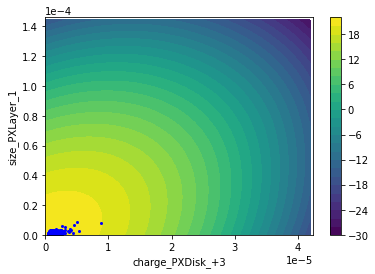

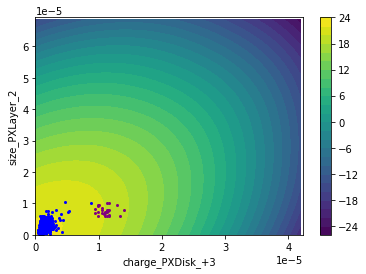

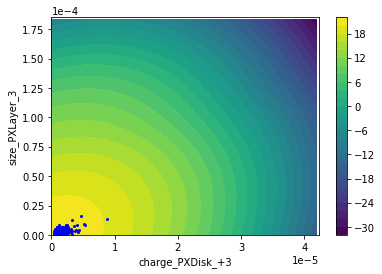

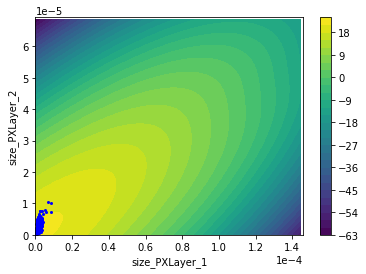

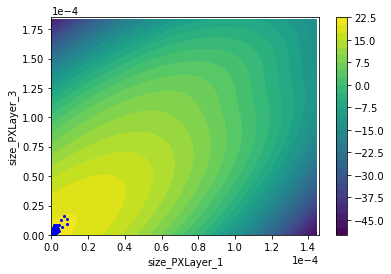

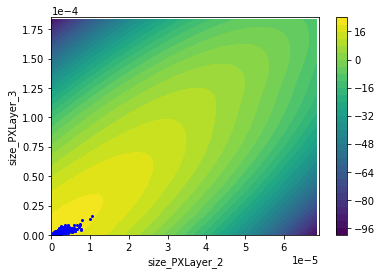

In [10]:
### make a new plot of probability contours and overlay data points
### (only 2D projections!)

use_ext = False

mse_good_eval = mse_good
mse_bad_eval = mse_bad
if use_ext:
    mse_good_eval = mse_good_ext
    mse_bad_eval = mse_bad_ext
    
plt.close('all')
colorlist = ['red','lightcoral','firebrick','chocolate','fuchsia','orange','purple']
#colorlist = ['red']*nbadsets
if len(colorlist)<nbadruns:
    print('### ERROR ###: need more colors...')

for dims,partialfitfunc in zip(dimslist,fitfunclist):
    fig,ax = pu.plot_fit_2d(mse_train[:,dims], fitfunc=partialfitfunc, logprob=True, onlycontour=True, 
                            xlims=100, ylims=100, 
                    onlypositive=True, xaxtitle=histstruct.histnames[dims[0]], 
                    yaxtitle=histstruct.histnames[dims[1]])
    for j in range(len(mse_bad_eval)): ax.plot(mse_bad_eval[j][:,dims[0]],mse_bad_eval[j][:,dims[1]],
                                               '.',color=colorlist[j],markersize=4)
    ax.plot(mse_good_eval[:,dims[0]],mse_good_eval[:,dims[1]],'.',color='blue',markersize=4)
    

# get the minimum log probability of histograms in good set
print('--- good lumesections ---')
logprob_good = np.log(fitfunc.pdf(mse_good_eval))
print('length of log prob array: '+str(len(logprob_good)))
print('minimum of log prob: '+str(np.min(logprob_good)))
#print(sorted(logprob_good))
print('--- bad lumisections ---')
logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(nbadruns)]
#for lp in logprob_bad_parts: print(str(sorted(lp))+'\n\n')
logprob_bad = np.concatenate(tuple(logprob_bad_parts))
print('length of log prob array: '+str(len(logprob_bad)))
print('maximum of log prob: '+str(np.max(logprob_bad)))
#print(sorted(logprob_good))
#print(sorted(logprob_bad))
#print(logprob_bad)

logprobs of -inf were reset to 88.04318104163221


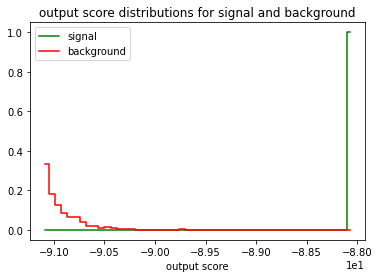

calculating roc curve:
  threshold: 1.0000, signal: 1.0000, background: 1.0000
  threshold: 1.0143, signal: 1.0000, background: 0.9523
  threshold: 1.0288, signal: 1.0000, background: 0.8428
  threshold: 1.0435, signal: 1.0000, background: 0.7509
  threshold: 1.0584, signal: 1.0000, background: 0.6787
  threshold: 1.0735, signal: 1.0000, background: 0.6088
  threshold: 1.0888, signal: 1.0000, background: 0.5669
  threshold: 1.1043, signal: 1.0000, background: 0.5250
  threshold: 1.1201, signal: 1.0000, background: 0.4889
  threshold: 1.1361, signal: 1.0000, background: 0.4494
  threshold: 1.1523, signal: 1.0000, background: 0.4168
  threshold: 1.1688, signal: 1.0000, background: 0.3749
  threshold: 1.1855, signal: 1.0000, background: 0.3527
  threshold: 1.2024, signal: 1.0000, background: 0.3295
  threshold: 1.2196, signal: 1.0000, background: 0.2969
  threshold: 1.2370, signal: 1.0000, background: 0.2759
  threshold: 1.2547, signal: 1.0000, background: 0.2584
  threshold: 1.2726, sign

../utils/autoencoder_utils.py:187: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax.set_ylim((ylowlim,1+(1-ylowlim)/5))


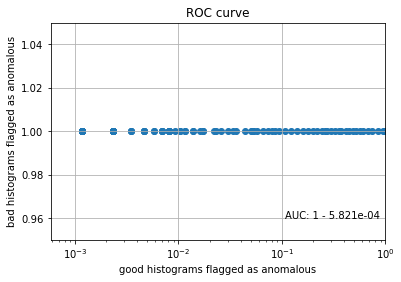

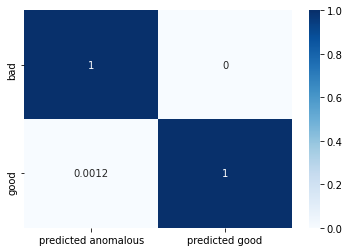

In [14]:
### make a roc curve based on the test results above
# note: smaller logprob = less probable = more outlier = more anomalous
# so if anomalies are signal and good histograms are background, -logprob is a suitable score definition,
# since everything above a certain threshold will be considered signal and below it background.

importlib.reload(aeu)

labels_good = np.zeros(len(logprob_good)) # background: label = 0
labels_bad = np.ones(len(logprob_bad)) # signal: label = 1

labels = np.concatenate(tuple([labels_good,labels_bad]))
scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
maxnoninf = np.max(np.where(scores==np.inf,np.min(scores),scores)) + 1
scores = np.where(scores==np.inf,maxnoninf,scores)
print('logprobs of -inf were reset to {}'.format(-maxnoninf))

pu.plot_score_dist(scores,labels,nbins=50, normalize=True)

auc = aeu.get_roc(scores, labels, mode='geom', doprint=True)
plt.show()

plt.figure()
logprob_threshold = 89 # everything below this logprob will be considered signal (i.e. anomalous)
aeu.get_confusion_matrix(scores,labels,-logprob_threshold)

mse (this histogram): 2.8100236246051232e-06
mse (average reference): 1.2256367055932886e-06
mse (this histogram): 3.894574032679945e-06
mse (average reference): 9.310450252022234e-07
mse (this histogram): 3.3760936877024917e-06
mse (average reference): 1.0191687640817854e-06
mse (this histogram): 4.330608494311919e-06
mse (average reference): 1.057062297539542e-06
mse (this histogram): 5.082173935375795e-06
mse (average reference): 1.3452490756236198e-06
mse (this histogram): 8.366847907081274e-06
mse (average reference): 1.3903872204937765e-06
mse (this histogram): 7.295686511671717e-06
mse (average reference): 2.5938573025497966e-06
mse (this histogram): 9.450140171865947e-06
mse (average reference): 2.8560649960117167e-06
logprob: [90.20970897]


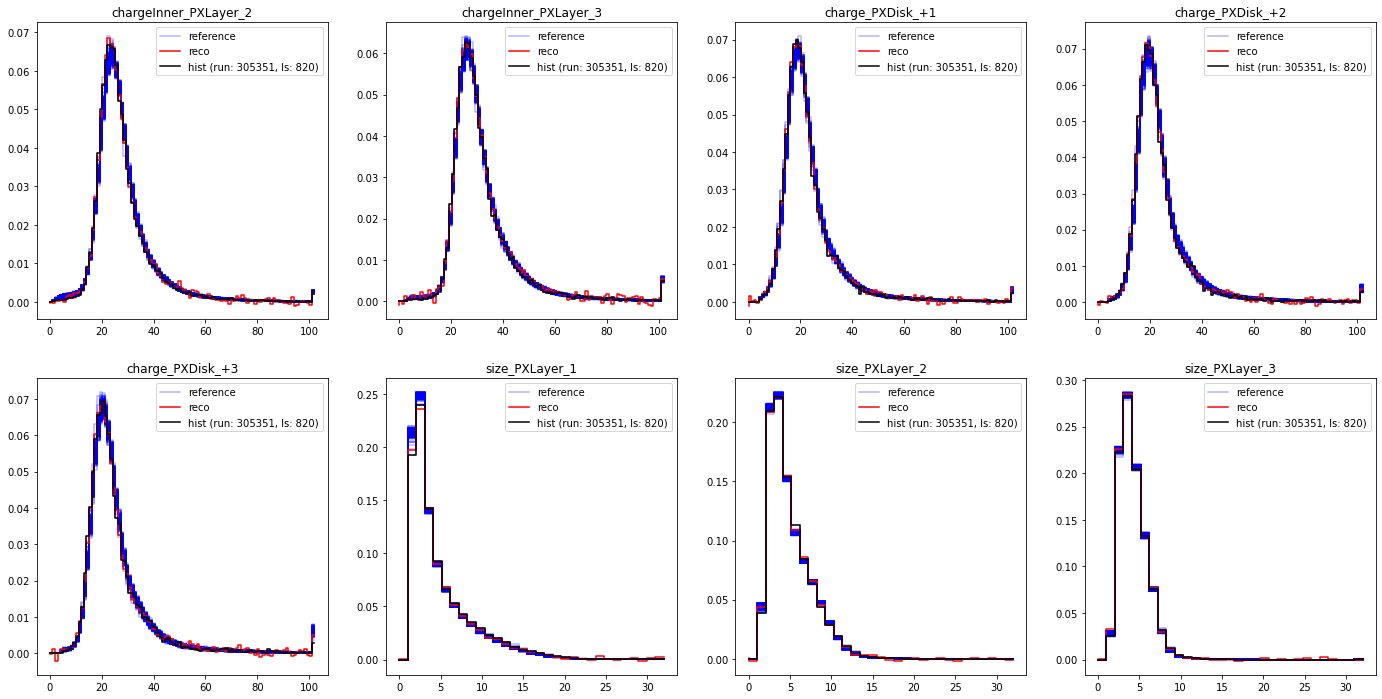

In [39]:
### investigate particular lumisections

importlib.reload(pu)

run = 305351
ls = 820
mode = 'ls'

#print(histstruct.runnbs[:10])
#print(histstruct.lsnbs[:10])

if mode=='ls':
    # plot this particular run/ls
    
    # define reference histograms
    if 'good' in histstruct.masks.keys(): refhists = histstruct.get_histograms(masknames=['highstat','dcson','good'])
    else: 
        refhists = {}
        for histname in histstruct.histnames:
            refhists[histname] = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat'] ), 15 )
    temp = histstruct.plot_ls( run, ls, recohist=True, refhists=refhists, doprint=True )
    msepoint = temp['scorepoint']
    logprob = np.log(fitfunc.pdf(np.array([msepoint])))
    print('logprob: '+str(logprob))

if mode=='run':
    # plot given run
    plot_run(histstruct_eval,run,histstruct_good)

In [56]:
### investigate OMS data: get data

sys.path.append('../omsinterface')
from get_oms_data import get_oms_data
# pileup and luminosity in good test set
oms_target_run = 306458
oms_info = get_oms_data( 'lumisections', oms_target_run, authmode='login' )

Enter CERN username:llambrec
Enter CERN password: ········
obtaining cookies for https://cmsoms.cern.ch/agg/api/v1/ from provided login for username llambrec ...


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/

obtaining cookies for https://cmsoms.cern.ch/agg/api/v1/ from provided login for username llambrec ...


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/

Total number of lumisections: 269





average pileup for this lumisection: 41.34059143


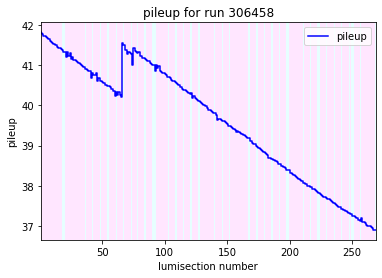

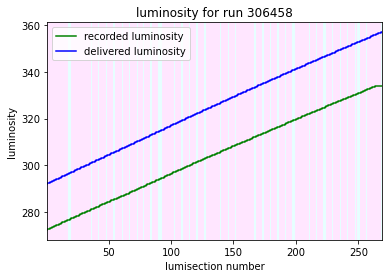

In [58]:
### investigate OMS data: make plots

oms_lsnbs = [el['lumisection_number'] for el in oms_info]
oms_dcson = jsonu.isdcson( [oms_target_run]*len(oms_lsnbs), oms_lsnbs )
pileup = [el['pileup'] for el in oms_info]
lumi_rec = [el['recorded_lumi'] for el in oms_info]
lumi_del = [el['delivered_lumi'] for el in oms_info]

doslice = False
if doslice:
    cropslice=slice(1000,None,None)
    oms_lsnbs = oms_lsnbs[cropslice]
    oms_dcson = oms_dcson[cropslice]
    pileup = pileup[cropslice]
    lumi_rec = lumi_rec[cropslice]
    lumi_del = lumi_del[cropslice]
    
_ = pu.plot_hists([pileup], colorlist=['b'], labellist=['pileup'], 
              xlims=(oms_lsnbs[0],oms_lsnbs[-1]),
              title='pileup for run {}'.format(oms_target_run), xaxtitle='lumisection number', yaxtitle='pileup',
              bkgcolor=oms_dcson,bkgcmap='cool')
_ = pu.plot_hists([lumi_rec,lumi_del], colorlist=['g','b'], labellist=['recorded luminosity','delivered luminosity'],
              xlims=(oms_lsnbs[0],oms_lsnbs[-1]),
              title='luminosity for run {}'.format(oms_target_run), xaxtitle='lumisection number', yaxtitle='luminosity',
              bkgcolor=oms_dcson,bkgcmap='cool')

lsnb = 20
idx_oms = np.where(np.array([el['lumisection_number'] for el in oms_info])==lsnb)[0][0]
print('average pileup for this lumisection: {}'.format(oms_info[idx_oms]['pileup']))

In [ ]:
### investigate how the method performs on the golden/custom test set

#evaljson = jsonu.loadjson('utils/json_pixel_good_201201.json')
#histstruct.add_json_mask( 'pixelgood', evaljson )
masks_eval = ['pixelgood', 'highstat']
lsnbs_eval = histstruct.get_lsnbs( masknames=masks_eval )
runnbs_eval = histstruct.get_runnbs( masknames=masks_eval )
mse_eval_dict = histstruct.get_scores( masknames=masks_eval )
mse_eval = []
for histname in histstruct.histnames:
    mse_eval.append( mse_eval_dict[histname] )
mse_eval = np.array(mse_eval)
mse_eval = np.transpose(mse_eval)
print('found mse array for evaluation set of following shape: {}'.format(mse_eval.shape))
logprob_eval = np.log(fitfunc.pdf(mse_eval))
print(logprob_eval)

def get_runsls_inrange(logprob,runnbs,lsnbs,logprob_up=None,logprob_down=None):
    # get a list of tuples of (run number, ls number) corresponding to ls with log probability within a given range
    # - logprob, runnbs and lsnbs are equally long 1D arrays
    # - logprob_up and logprob_down are upper and lower thresholds
    #     if both are not None, the lumisections with logprob between the boundaries are returned
    #     if logprob_up is None, the lumisections with logprob > logprob_down are returned
    #     if logprob_down is None, the lumisections with logprob < logprob_up are returned
    indices = np.array([])
    if logprob_down is None:
        indices = np.nonzero(logprob<logprob_up)[0]
    elif logprob_up is None:
        indices = np.nonzero(logprob>logprob_down)[0]
    else:
        indices = np.nonzero((logprob>logprob_down) & (logprob<logprob_up))[0]
    runsinrange = runnbs[indices]
    lsinrange = lsnbs[indices]
    runslsinrange = []
    for rr,lsr in zip(runsinrange,lsinrange):
        runslsinrange.append((int(rr),int(lsr)))
    return {'indices':indices,'runslsinrange':runslsinrange}

logup = 40
logdown = None
temp = get_runsls_inrange(logprob_eval, runnbs_eval, lsnbs_eval,
                          logprob_up = logup, logprob_down = logdown)

runslsinrange = temp['runslsinrange']
print('{} out of {} LS are within these boundaries'.format(len(runslsinrange),len(logprob_eval)))

# make plots
nplotsmax = 10
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('test.pdf')
for i,(runnb,lsnb) in enumerate(runslsinrange):
    if i>=nplotsmax:
        print('maximum number of plots reached')
        break
    print('------------------------')
    temp = histstruct.plot_ls( runnb, lsnb, refhists)
    msepoint = temp['scorepoint']
    fig = temp['figure']
    fig.show()
    pdf.savefig(fig)
    # only for 2 dimensions: extra contour plot
    #if nhisttypes != 2: continue
    #fig,ax = plt.subplots()
    #contourplot = ax.contourf(x, y, np.log(fitfunc.pdfgrid(pos)))
    #plt.colorbar(contourplot)
    #ax.plot(msepoint[0],msepoint[1],'.k',markersize=10)
    #ax.set_xlim((0.,xlim))
    #ax.set_ylim((0.,ylim))
pdf.close()